# Modelling Rogue Wave Data with Linear Regression

In [1]:
%load_ext autoreload
%autoreload 2

## Setup
### Imports

Importing all required packages and define seed and number of cores to use.

In [2]:
import os
import sys

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet

sys.path.append('./')
sys.path.append('../scripts/')
import utils

### Parameter Settings

In [3]:
seed = 42
n_jobs = 4
print(f"Using {n_jobs} cores from {os.cpu_count()} available cores.") # how many CPU cores are available on the current machine

Using 4 cores from 8 available cores.


We load the data that was preprocessed in `data_preprocessing.ipynb`.  

In [4]:
file_data = "../data/data_train_test.pickle"  # path to the preprocessed data
data_train, data_test, y_train, y_train_cat, X_train, y_test, y_test_cat, X_test = utils.load_data(file_data)

Loading data...

Training dataset target distribution:
Counter({1: 489544, 0: 334909, 2: 14264})

Test dataset target distribution:
Counter({1: 122387, 0: 83727, 2: 3566})


Before training the Elastic Net model, we need to standarize the data with the Standard Scaler.

In [5]:
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

## Building an ElasticNet Regression Model

Here we use an ElasticNet model because it combines L1 and L2 regularization, allowing for both feature selection and stability in the presence of highly correlated environmental variables. This makes it well-suited for identifying a sparse yet robust set of predictive features without overfitting in a high-dimensional setting.

### Instantiating the Model and Setting Hyperparameters

- `l1_ratio`: The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. Only used if penalty='elasticnet'. Setting l1_ratio=0 is equivalent to using penalty='l2', while setting l1_ratio=1 is equivalent to using penalty='l1'. For 0 < l1_ratio <1, the penalty is a combination of L1 and L2.
- `selection`: If set to ‘random’, a random coefficient is updated every iteration rather than looping over features sequentially by default. This (setting to ‘random’) often leads to significantly faster convergence especially when tol is higher than 1e-4.

In [6]:
num_cv = 5

hyperparameter_grid = { 
    'l1_ratio': [0, 0.2, 0.4, 0.5, 0.6, 0.8, 1],
    'selection': ['cyclic', 'random'] 
}

In [7]:
regressor = ElasticNet(random_state=seed)

### Train the Model

For hyperparameter tuning, we use a k-fold crossvalidation with a stratified splitter that ensures we have enough rogue wave data in the training and validation set.

In [8]:
# Run CV
model, cv_results = utils.run_CV(regressor, hyperparameter_grid, num_cv, X_train_transformed, y_train_cat, y_train)
cv_results = cv_results.sort_values(by="score", ascending=False)

file_cv = f"../results/linear_model/cv_results.csv"
cv_results.to_csv(file_cv)

/opt/anaconda3/envs/rw/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.625e+03, tolerance: 2.010e+00
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/rw/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.608e+03, tolerance: 2.007e+00
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_mo

### Evaluate the Model

For evaluation use MSE, R^2 and Spearman correlation.

Evaluate on Training Set
Train set MSE: 0.028
Train set R^2: 0.053
Train set Spearman R: 0.236


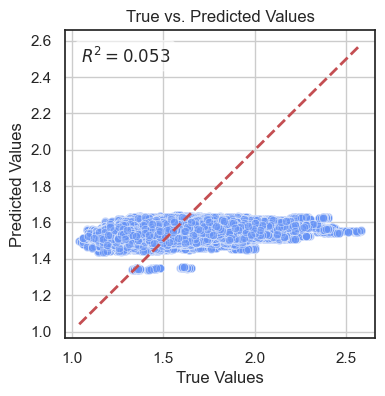

Evaluate on Test Set
Train set MSE: 0.028
Train set R^2: 0.055
Train set Spearman R: 0.239


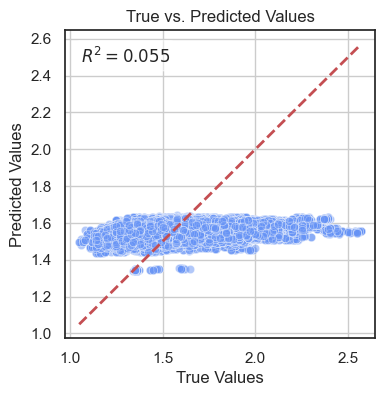

In [9]:
# Evaluate model on train and test set
utils.evaluate_best_regressor(model, X_train_transformed, y_train, dataset="Training", plot=True)
utils.evaluate_best_regressor(model, X_test_transformed, y_test, dataset="Test", plot=True)

Conclusion: the CV results of the Elastic Net model are too bad to continue, i.e. we don't bother further tuning hyperparameters or evaluating on the test set.